Python Imports

In [19]:
from netCDF4 import Dataset
import numpy as np
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import matplotlib.pyplot as plt
from pyproj import Proj
from shapely.geometry import shape

Pre Defined Stuff

In [20]:
# Date Stuff
syr=2010
eyr=2010
nyr=eyr-syr+1
nmpyr=12
ndaypyr=366

# lats/lons
nx=144
ny=73

# day of year
idy=6

# AtlanticNa Region [230E-350E; 30N-70N]
region=[0,360,30,70]


Read NCEP/NCAR 500 hPa daily data for 2009

In [21]:
inPath='/shared/ccsm4/kpegion/obs2/NCEPR1/hgt'

for iyr in range(syr,eyr+1):
    inFile='%s/hgt.%s.nc' %(inPath,iyr)
    print(inFile)
    ncfile=Dataset(inFile,'r')
    
    # If its the first year, get the lon, lat, level information
    if iyr == syr:
       lat = ncfile.variables['lat'][:]
       ny=len(lat)
       lat=np.flip(lat)
       lon = ncfile.variables['lon'][:]
       nx=len(lon)
       levs = np.array(ncfile.variables['level'][:])
       plev=np.where(levs==500)[0]
       nctime = ncfile.variables['time'][:]
       nt=len(nctime)   
      
       # Read Z500 JAS
       z500 = ncfile.variables['hgt'][idy,plev,:,:]
       z500=np.flip(z500,axis=1)
       

/shared/ccsm4/kpegion/obs2/NCEPR1/hgt/hgt.2010.nc


Extract AtlanticNA Region

In [22]:
# Get Lon/Lat info
latli = np.argmin( np.abs( lat - region[2] ) )
latui = np.argmin( np.abs( lat - region[3] ) )
lonli = np.argmin( np.abs( lon - region[0] ) )
lonui = np.argmin( np.abs( lon - region[1] ) )

nxreg=lonui-lonli+1
nyreg=latui-latli+1
nxnyreg=nxreg*nyreg

latsReg=lat[latli:latui+1]
lonsReg=lon[lonli:lonui+1]
nxReg=lonsReg.size
nyReg=latsReg.size
print(nxReg, nyReg)

# Extract the data for this region
REG=z500[0,latli:latui+1,lonli:lonui+1]
isopleth=np.mean(np.mean(REG,axis=0))
print(REG.shape)
print(isopleth)

144 17
(17, 144)
5427.1274


Make a plot of the region for Jan 10, 2010 -- should match Cattiaux et al. 2016

(144,)
(17,)


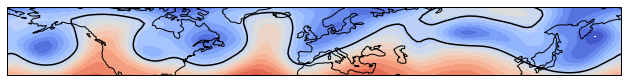

In [23]:
fig = plt.figure(figsize=(11,8.5))
ax=plt.axes(projection=ccrs.PlateCarree())
clevs = np.arange(5100,6000,50)
x=np.ones((nyReg,nxReg))*REG[:,np.newaxis]
datacyc,loncyc=add_cyclic_point(REG[:,:],coord=lonsReg)
contour=ax.contourf(loncyc, latsReg, datacyc,levels=clevs,cmap=plt.cm.coolwarm, transform = ccrs.PlateCarree())
ax.coastlines()
#ax.plt.colorbar(contour)
contourlines=ax.contour(lonsReg, latsReg, REG,levels=[isopleth],transform=ccrs.PlateCarree(),colors='black')
print(lonsReg.shape)
print(latsReg.shape)

Get the contour lines -- it gives me x,y points

(236,)
(236,)


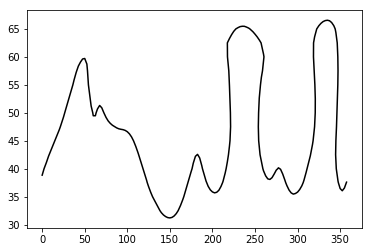

In [24]:
p = contourlines.collections[0].get_paths()[0]
v = p.vertices
x = v[:,0]
y = v[:,1]   
print(x.shape)
print(y.shape)
plt.plot(x,y,color='black')

Now I need the distance of this contour line on a sphere given the lats and lons -- R has that perimeter function, but I cannot find anything similar in Python

In [25]:
pa = Proj("+proj=aea +lat_1=30 +lat_2=70 +lat_0=0 +lon_0=360")
x2, y2 = pa(x, y)
cop = {"type": "Polygon", "coordinates": [zip(x2, y2)]}
Asinuosity=shape(cop).area  # 268952044107.43506
print(Asinuosity)

100282893104442.86


Calculate length of 50N circle

In [26]:
y3=y
y3[:]=50
x2, y2 = pa(x, y3)
cop = {"type": "Polygon", "coordinates": [zip(x2, y2)]}
A50=shape(cop).area  # 268952044107.43506
print(A50)

print(Asinuosity/A50)

79051230069584.0
1.268581058336093
